In [6]:
!pip install equinox optax

In [7]:
import jax
import jax.numpy as jnp
import equinox as eqx


class NNet(eqx.Module):
  layers: list

  def __init__(self, key):
    keys = jax.random.split(key, 9)
    self.layers = [
        eqx.nn.Linear(2, 20, key=keys[0]),
        eqx.nn.Linear(20, 20, key=keys[1]),
        eqx.nn.Linear(20, 20, key=keys[2]),
        eqx.nn.Linear(20, 20, key=keys[3]),
        eqx.nn.Linear(20, 20, key=keys[4]),
        eqx.nn.Linear(20, 20, key=keys[5]),
        eqx.nn.Linear(20, 20, key=keys[6]),
        eqx.nn.Linear(20, 20, key=keys[7]),
        eqx.nn.Linear(20, 1, key=keys[8]),
    ]

  def __call__(self, tx):
    # Rescale t to [-1, 1] to match x domain scale.
    t, x = tx
    z = jnp.array([2.0 * t - 1.0, x])
    for layer in self.layers[:-1]:
      z = jnp.tanh(layer(z))
    return self.layers[-1](z)[0]

In [8]:
import jax.numpy as jnp
nu = 0.01 / jnp.pi


def u_scalar(model, t, x):
  return model(jnp.array([t, x]))


def burgers_residual(model, t, x):
  u = u_scalar(model, t, x)
  u_t = jax.grad(lambda tt: u_scalar(model, tt, x))(t)
  u_x = jax.grad(lambda xx: u_scalar(model, t, xx))(x)
  u_xx = jax.grad(lambda xx: jax.grad(lambda xxx: u_scalar(model, t, xxx))(xx))(x)
  return u_t + u * u_x - nu * u_xx


def mse_u(model, Tu, Xu, Uu):
  TX = jnp.stack([Tu, Xu], axis=1)
  u_pred = jax.vmap(model)(TX)
  return jnp.mean((u_pred - Uu)**2)


def mse_f(model, Tf, Xf):
  f_pred = jax.vmap(lambda t, x: burgers_residual(model, t, x))(Tf, Xf)
  return jnp.mean(f_pred ** 2)


def mse_loss(model, batch_u, batch_f):
  Tu, Xu, Uu = batch_u
  Tf, Xf = batch_f
  return mse_u(model, Tu, Xu, Uu) + mse_f(model, Tf, Xf)


In [9]:
import jax
import jax.numpy as jnp


def sample_u_points(key, Nu):
    k1, k2, k3 = jax.random.split(key, 3)
    Nu_ic = Nu // 2
    Nu_bc = Nu - Nu_ic

    x_ic = jax.random.uniform(k1, (Nu_ic,), minval=-1.0, maxval=1.0)
    t_ic = jnp.zeros((Nu_ic,))
    u_ic = -jnp.sin(jnp.pi * x_ic)

    t_bc = jax.random.uniform(k2, (Nu_bc,), minval=0.0, maxval=1.0)
    side = jax.random.bernoulli(k3, 0.5, (Nu_bc,))
    x_bc = jnp.where(side, -1.0, 1.0)
    u_bc = jnp.zeros((Nu_bc,))

    Tu = jnp.concatenate([t_ic, t_bc])
    Xu = jnp.concatenate([x_ic, x_bc])
    Uu = jnp.concatenate([u_ic, u_bc])
    return Tu, Xu, Uu


def latin_hypercube_1d(key, n, low, high):
    k1, k2 = jax.random.split(key)
    u = jax.random.uniform(k1, (n,))
    perm = jax.random.permutation(k2, n)
    bins = (perm.astype(jnp.float32) + u) / n
    return low + (high - low) * bins


def sample_f_points(key, Nf):
    kt, kx = jax.random.split(key)
    t = latin_hypercube_1d(kt, Nf, 0.0, 1.0)
    x = latin_hypercube_1d(kx, Nf, -1.0, 1.0)
    return t, x

In [ ]:
import equinox as eqx
import optax


key = jax.random.PRNGKey(0)
model = NNet(key)

# Match paper setup: fixed training and collocation points (full-batch).
Nu = 100
Nf = 10_000
key, ku, kf = jax.random.split(key, 3)
batch_u = sample_u_points(ku, Nu)
batch_f = sample_f_points(kf, Nf)

params, static = eqx.partition(model, eqx.is_array)


def loss_from_params(params, static, batch_u, batch_f):
    model_ = eqx.combine(params, static)
    return mse_loss(model_, batch_u, batch_f)


# Full-batch L-BFGS for Burgers benchmark.
lbfgs = optax.lbfgs(learning_rate=1.0, memory_size=20)
lbfgs_state = lbfgs.init(params)
value_and_grad = optax.value_and_grad_from_state(loss_from_params)
lbfgs_steps = 3000


@eqx.filter_jit
def lbfgs_step(params, lbfgs_state, static, batch_u, batch_f):
    value, grads = value_and_grad(
        params,
        state=lbfgs_state,
        static=static,
        batch_u=batch_u,
        batch_f=batch_f,
    )
    updates, lbfgs_state = lbfgs.update(
        grads,
        lbfgs_state,
        params,
        value=value,
        grad=grads,
        value_fn=loss_from_params,
        static=static,
        batch_u=batch_u,
        batch_f=batch_f,
    )
    params = optax.apply_updates(params, updates)
    return params, lbfgs_state, value


for step in range(lbfgs_steps):
    params, lbfgs_state, value = lbfgs_step(params, lbfgs_state, static, batch_u, batch_f)

    if step % 100 == 0:
        print(f"lbfgs {step:4d} total={float(value):.6f}")

model = eqx.combine(params, static)

Tu, Xu, Uu = batch_u
Tf, Xf = batch_f
l_u = mse_u(model, Tu, Xu, Uu)
l_f = mse_f(model, Tf, Xf)
print(f"done total={float(l_u + l_f):.6f} mse_u={float(l_u):.6f} mse_f={float(l_f):.6f}")

lbfgs    0 total=0.258995
lbfgs  100 total=0.088987
lbfgs  200 total=0.054592
lbfgs  300 total=0.040826
lbfgs  400 total=0.033313
lbfgs  500 total=0.020018
lbfgs  600 total=0.011505
lbfgs  700 total=0.006424
lbfgs  800 total=0.003616
lbfgs  900 total=0.002564
lbfgs 1000 total=0.001635
lbfgs 1100 total=0.001192
lbfgs 1200 total=0.000859
lbfgs 1300 total=0.000679
lbfgs 1400 total=0.000582
lbfgs 1500 total=0.000463
lbfgs 1600 total=0.000390
lbfgs 1700 total=0.000326
lbfgs 1800 total=0.000283
lbfgs 1900 total=0.000260
lbfgs 2000 total=0.000229
lbfgs 2100 total=0.000197
lbfgs 2200 total=0.000180
lbfgs 2300 total=0.000155
lbfgs 2400 total=0.000136
lbfgs 2500 total=0.000117
lbfgs 2600 total=0.000107
lbfgs 2700 total=0.000098
lbfgs 2800 total=0.000090
lbfgs 2900 total=0.000082
done total=0.000076 mse_u=0.000013 mse_f=0.000063


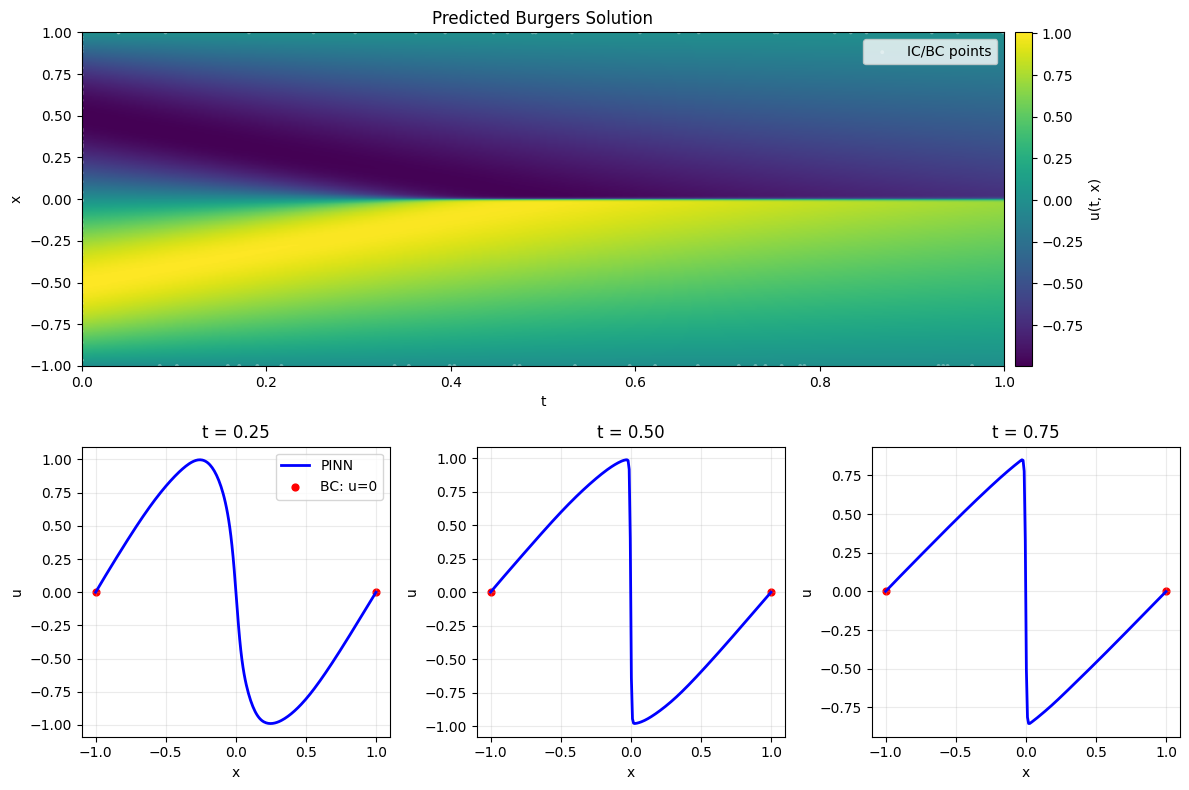

In [12]:
import numpy as np
import matplotlib.pyplot as plt


t_eval = np.linspace(0.0, 1.0, 256)
x_eval = np.linspace(-1.0, 1.0, 256)
TT, XX = np.meshgrid(t_eval, x_eval, indexing="ij")

TX_eval = jnp.stack(
    [jnp.asarray(TT).reshape(-1), jnp.asarray(XX).reshape(-1)], axis=1
)
U_pred = np.asarray(jax.vmap(model)(TX_eval)).reshape(TT.shape)

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 3, height_ratios=[1.15, 1.0])

ax0 = fig.add_subplot(gs[0, :])
im = ax0.imshow(
    U_pred.T,
    extent=[0.0, 1.0, -1.0, 1.0],
    origin="lower",
    aspect="auto",
    cmap="viridis",
)
fig.colorbar(im, ax=ax0, pad=0.01, label="u(t, x)")
ax0.set_title("Predicted Burgers Solution")
ax0.set_xlabel("t")
ax0.set_ylabel("x")

Tu, Xu, _ = batch_u
ax0.scatter(np.asarray(Tu), np.asarray(Xu), s=8, c="white", alpha=0.35, edgecolors="none", label="IC/BC points")
ax0.legend(loc="upper right")

t_slices = [0.25, 0.50, 0.75]
for i, t0 in enumerate(t_slices):
    ax = fig.add_subplot(gs[1, i])
    tidx = int(np.argmin(np.abs(t_eval - t0)))
    ax.plot(x_eval, U_pred[tidx, :], "b-", lw=2, label="PINN")

    ax.set_title(f"t = {t0:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("u")
    ax.grid(alpha=0.25)

    ax.scatter([-1.0, 1.0], [0.0, 0.0], c="r", s=24, label="BC: u=0")

    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()